In [13]:
import matplotlib.pyplot as plt
import numpy as np
def visualize_reconstruction(decoder,encoder , test_data, num_images=10):
    # Выберите случайные изображения
    indices = np.random.choice(len(test_data), num_images)
    original_images = test_data[indices]
    reconstructed_images = [decoder.forward(encoder.forward(img.reshape(1, -1))[0]) for img in original_images]

    # Построение графика
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        # Оригинал
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title("Original")
        # Реконструкция
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title("Reconstructed")
    plt.show()


In [14]:
from VAE import Encoder, Decoder, Discriminator, VAEGANTrainer
from tensorflow.keras.datasets import mnist
import numpy as np

# Инициализация
# Инициализация
# Подготовка данных
def preprocess_data(x):
    x = x.astype('float32') / 255.0
    return x.reshape(x.shape[0], -1)

# Загрузка данных MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = preprocess_data(x_train)

# Инициализация моделей
encoder = Encoder(learning_rate= 1e-4) # Ниже 1e-6 значения kl улаетает \
decoder = Decoder(learning_rate=1e-4)

# Обучение
trainer = VAEGANTrainer(encoder, decoder, beta=0.01) #0.05
trainer.train(x_train, batch_size=32, epochs=15) #20


Epoch 1/15 - VAE Loss: 67.9273 - GAN Loss: 0.0000 - Recon Loss: 59.3116 - KL Loss: 0.0862
Epoch 2/15 - VAE Loss: 50.6931 - GAN Loss: 0.0000 - Recon Loss: 36.4163 - KL Loss: 0.1428
Epoch 3/15 - VAE Loss: 48.4391 - GAN Loss: 0.0000 - Recon Loss: 33.5456 - KL Loss: 0.1489
Epoch 4/15 - VAE Loss: 48.4074 - GAN Loss: 0.0000 - Recon Loss: 31.9081 - KL Loss: 0.1650
Epoch 5/15 - VAE Loss: 48.5539 - GAN Loss: 0.0000 - Recon Loss: 30.8581 - KL Loss: 0.1770
Epoch 6/15 - VAE Loss: 48.7393 - GAN Loss: 0.0000 - Recon Loss: 30.2842 - KL Loss: 0.1846
Epoch 7/15 - VAE Loss: 48.8936 - GAN Loss: 0.0000 - Recon Loss: 29.7293 - KL Loss: 0.1916
Epoch 8/15 - VAE Loss: 49.2140 - GAN Loss: 0.0000 - Recon Loss: 29.1837 - KL Loss: 0.2003
Epoch 9/15 - VAE Loss: 49.5453 - GAN Loss: 0.0000 - Recon Loss: 28.8817 - KL Loss: 0.2066
Epoch 10/15 - VAE Loss: 49.6843 - GAN Loss: 0.0000 - Recon Loss: 28.6661 - KL Loss: 0.2102
Epoch 11/15 - VAE Loss: 49.7407 - GAN Loss: 0.0000 - Recon Loss: 28.4751 - KL Loss: 0.2127
Epoch 12

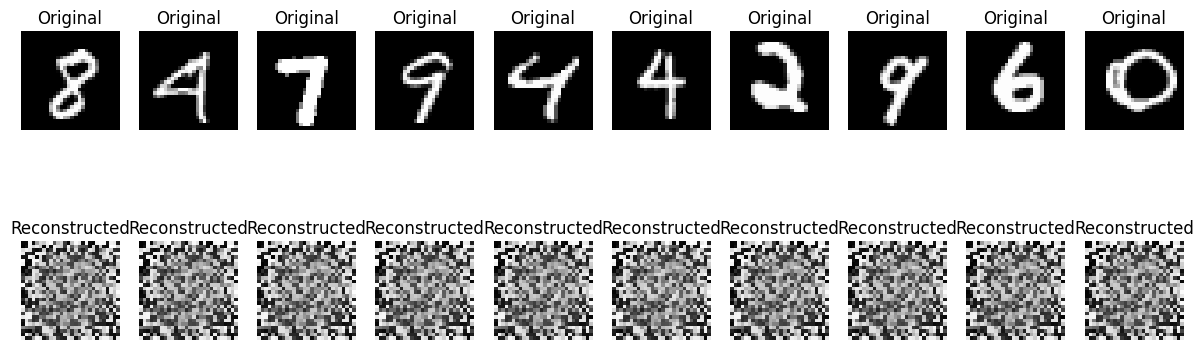

In [21]:
visualize_reconstruction(decoder=decoder, encoder=encoder, test_data=x_test)

In [16]:
from main_cl import Fullyconnected
from activations import LeakyRelu, Tanh, Sigmoid, Relu

class Discriminator:
    def __init__(self, input_size=784, arch=(256, 128, 64), learning_rate=1e-8):
        self.fc1 = Fullyconnected(input_size=input_size, output_size=arch[0])
        self.LeakyRelu1 = Relu()
        self.fc2 = Fullyconnected(input_size=arch[0], output_size=arch[1])
        self.LeakyRelu2 = Relu()
        self.fc3 = Fullyconnected(input_size=arch[1], output_size=arch[1])
        self.LeakyRelu3 = Relu()
        self.fc4 = Fullyconnected(input_size=arch[1], output_size=1)
        self.sig = Sigmoid()
        self.lr = learning_rate

        self.layers = [
            self.fc1,
            self.LeakyRelu1,
            self.fc2,
            self.LeakyRelu2,
            self.fc3,
            self.LeakyRelu3,
            self.fc4,
            self.sig
        ]

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, dout):
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    def backward_(self, dout):
        for layer in reversed(self.layers):
            dout = layer.backward_(dout)
        return dout
    
    def update_params(self):
        for layer in self.layers:
            if 'activations' not in str(layer.__class__):
                if 'Flatten' not in str(layer.__class__):
                    layer.update_params(self.lr)


        

class GAN_:
    def __init__(self, generator, discriminator, beta=1, dec_reg=1):
        self.generator = generator
        self.discriminator = discriminator
        self.beta = beta
        self.dec_reg = dec_reg

    def forward(self, x):
        batch_size = x.shape[0]
        # Генерация фейковых данных
        noise = np.random.normal(0, 1, (batch_size, self.generator.zdims))
        fake_data = self.generator.forward(noise)
        real_preds = self.discriminator.forward(x)
        fake_preds = self.discriminator.forward(fake_data)
        return real_preds, fake_preds, fake_data

    def binary_l(self, predictions, targets):
        """Бинарная кросс-энтропия."""
        predictions = np.clip(predictions, 1e-8, 1 - 1e-8)  # Для стабильности
        grad = (predictions - targets) / (predictions * (1 - predictions))
        grad /= targets.shape[0]  # Нормализация по числу примеров в батче
        loss = -np.mean(targets * np.log(predictions) + (1 - targets) * np.log(1 - predictions))
        return loss, grad

    def train(self, x_train, batch_size=128, epochs=50):
        self.total_d_loss, self.total_g_loss = [], []

        for epoch in range(epochs):
            total_d_loss, total_g_loss = 0, 0

            for i in range(0, len(x_train), batch_size):
                x_batch = x_train[i:i + batch_size]

                real_labels = np.ones((x_batch.shape[0], 1))
                fake_labels = np.zeros((x_batch.shape[0], 1))

                # === Forward Pass ===
                real_preds, fake_preds, fake_data = self.forward(x_batch)

                # === Discriminator Loss ===
                d_loss_real, dgrad_real = self.binary_l(real_preds, real_labels)
                d_loss_fake, dgrad_fake = self.binary_l(fake_preds, fake_labels)
                total_d_loss += dgrad_real + dgrad_fake
                self.discriminator.backward(total_d_loss)
                self.discriminator.update_params()

                # === Generator Loss ===
                g_loss, ggrad_fake = self.binary_l(fake_preds, real_labels)  # Целевые метки "1"
                total_g_loss += g_loss


                # === Update Generator ===
                self.generator.backward(self.discriminator.backward_(ggrad_fake))
                self.generator.update_params()

            # === Logging ===
            avg_d_loss = total_d_loss / (len(x_train) / batch_size)
            avg_g_loss = total_g_loss / (len(x_train) / batch_size)
            self.total_d_loss.append(avg_d_loss)
            self.total_g_loss.append(avg_g_loss)
            
            print(f"Epoch {epoch + 1}/{epochs} - D Loss: {avg_d_loss:.4f} - G Loss: {avg_g_loss:.4f}")

In [17]:
discriminator = Discriminator(learning_rate=1e-8)
tr = GAN_(decoder, discriminator)
tr.train(x_train, batch_size=32, epochs=10) #20

TypeError: unsupported format string passed to numpy.ndarray.__format__

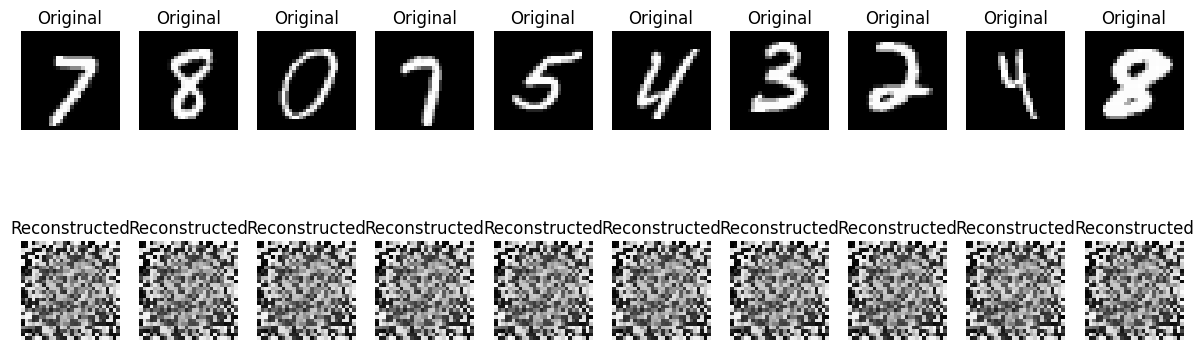

In [22]:
visualize_reconstruction(decoder=decoder, encoder=encoder, test_data=x_test)

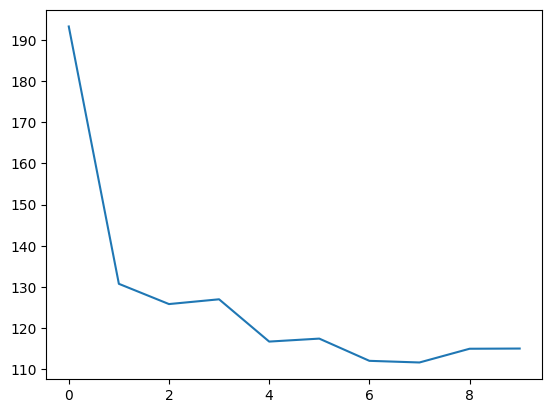

In [2]:
import matplotlib.pyplot as plt
plt.plot(trainer.recon_loss_history)

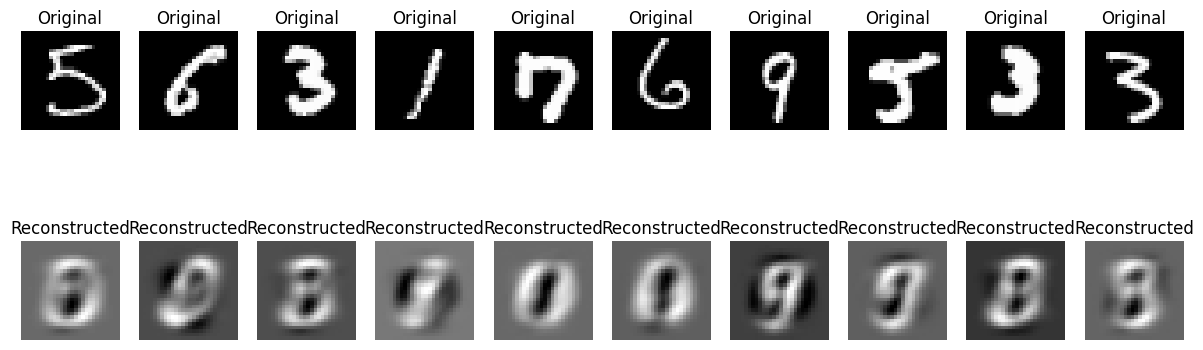

In [3]:
visualize_reconstruction(trainer, x_test)

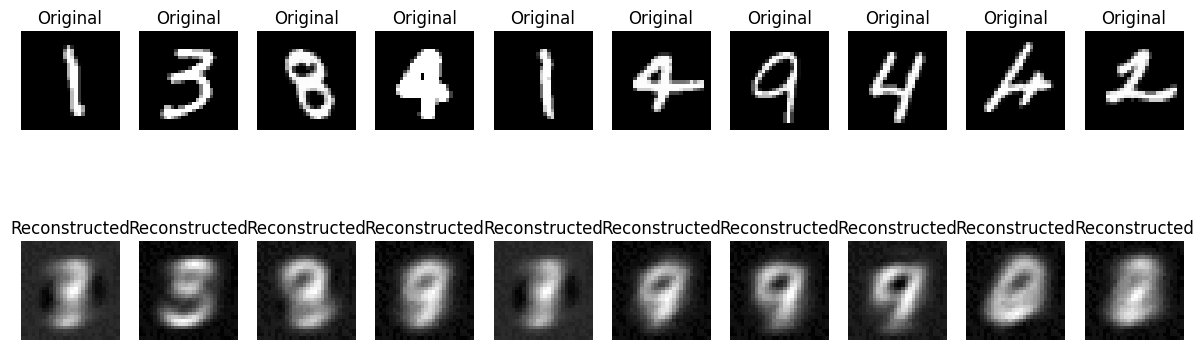

In [5]:
visualize_reconstruction(trainer, x_test)

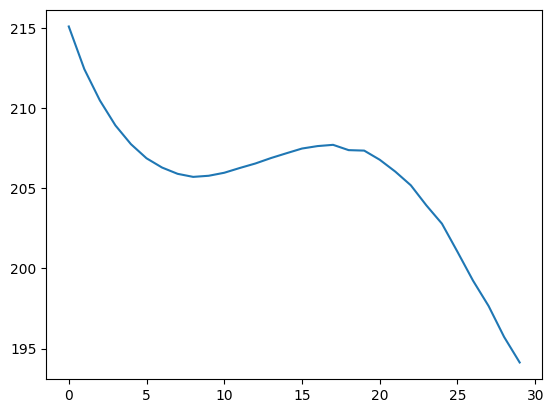

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def visualize_latent_space(encoder, test_data, labels, latent_dim=2, sample_size=1000):
    """
    Визуализация латентного пространства с использованием t-SNE.

    :param encoder: Тренированный энкодер (должен возвращать mu, logvar).
    :param test_data: Тестовые данные (например, изображения MNIST).
    :param labels: Метки тестовых данных.
    :param latent_dim: Размер латентного пространства.
    :param sample_size: Количество точек для визуализации.
    """
    # Выбор подмножества данных
    indices = np.random.choice(len(test_data), sample_size, replace=False)
    sampled_data = test_data[indices]
    sampled_labels = labels[indices]

    # Пропуск данных через энкодер
    latent_representations = []
    for img in sampled_data:
        mu, _ = encoder.forward(img.reshape(1, -1))  # Только mu из z ~ N(mu, sigma^2)
        latent_representations.append(mu.flatten())
    latent_representations = np.array(latent_representations)

    # Если латентное пространство не 2D, используем t-SNE
    if latent_dim > 2:
        tsne = TSNE(n_components=2, random_state=42)
        latent_representations_2d = tsne.fit_transform(latent_representations)
    else:
        latent_representations_2d = latent_representations

    # Визуализация
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        latent_representations_2d[:, 0],
        latent_representations_2d[:, 1],
        c=sampled_labels,
        cmap='tab10',
        alpha=0.7
    )
    plt.colorbar(scatter, label='Digit Labels')
    plt.title('Latent Space Visualization')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()


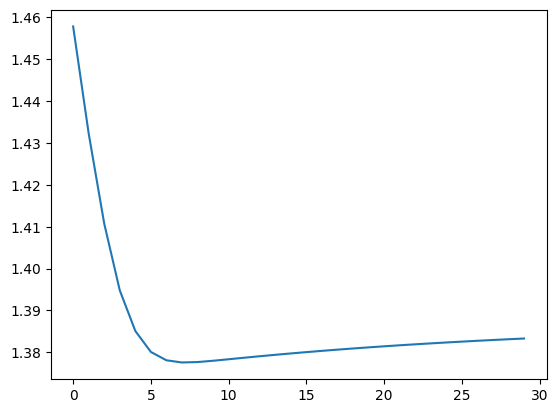

In [ ]:
visualize_latent_space(trainer.encoder, test_data=x_test, mnist_test_labels  )

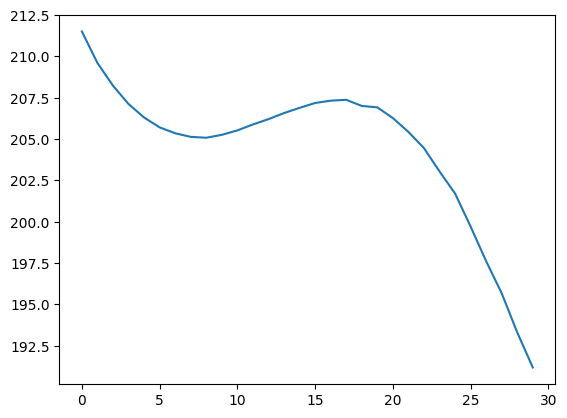

In [7]:
from matplotlib import pyplot as plt

plt.plot(trainer.recon_loss_history)

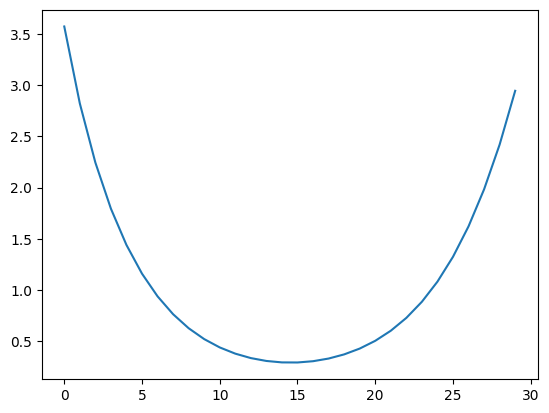

: 

In [ ]:
from matplotlib import pyplot as plt

plt.plot(trainer.kl_loss_history)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_reconstruction(vae_trainer, x_test, num_images=10):
    """
    Visualize the reconstruction of images by the VAE.
    """
    # Select random images
    idx = np.random.choice(len(x_test), num_images, replace=False)
    original_images = x_test[idx]

    # Get reconstructed images
    reconstructed_images, _, _ = vae_trainer.forward(original_images)

    # Plot original and reconstructed images
    fig, axes = plt.subplots(2, num_images, figsize=(15, 4))
    for i in range(num_images):
        # Original images
        axes[0, i].imshow(original_images[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")
        
        # Reconstructed images
        axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")
    plt.show()

def visualize_latent_space(vae_trainer, x_test, y_test):
    """
    Visualize the latent space for a 2D latent dimension.
    """
    # Encode images to latent space
    mu, _ = vae_trainer.encoder.forward(x_test)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='viridis', s=2)
    plt.colorbar(scatter, label="Class")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space Visualization")
    plt.show()

def generate_samples(vae_trainer, grid_size=10, latent_range=(-3, 3)):
    """
    Generate images by sampling the latent space.
    """
    # Create a grid of latent space values
    grid_x = np.linspace(latent_range[0], latent_range[1], grid_size)
    grid_y = np.linspace(latent_range[0], latent_range[1], grid_size)
    grid = np.array(np.meshgrid(grid_x, grid_y)).T.reshape(-1, 2)

    # Decode the grid
    generated_images = vae_trainer.decoder.forward(grid)

    # Plot the generated images
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    for i in range(grid_size):
        for j in range(grid_size):
            img = generated_images[i * grid_size + j].reshape(28, 28)
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
    plt.show()

visualize_reconstruction(vae_trainer, x_test)
visualize_latent_space(vae_trainer, x_test, y_test)
generate_samples(vae_trainer)


NameError: name 'vae_trainer' is not defined